In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.chdir("/nas/ucb/oliveradk/diverse-gen/")


In [2]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments, get_conf_dir
from utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results
from utils.utils import conf_to_args

In [24]:
SCRIPT_NAME = "spur_corr_exp.py"
EXP_DIR = Path("output/cc_known_mix_rate_exps")
SUB_DIR = "2025-02-06_17-03-07" #None 
if SUB_DIR is None:
    SUB_DIR = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
EXP_DIR = Path(EXP_DIR, SUB_DIR)

EXP_DIR.mkdir(parents=True, exist_ok=True)
(EXP_DIR / "results").mkdir(parents=True, exist_ok=True)
(EXP_DIR / "figures").mkdir(parents=True, exist_ok=True)

# Define Configs

In [4]:
# shared configs
BATCH_SIZE = 32 
TARGET_BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-4
OPTIMIZER = "adamw"

# seeds
SEEDS = [1, 2, 3]

# mix rates
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# datasets 
datasets = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": BATCH_SIZE, "target_batch_size": 128, "plot_activations": False},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "cifar_mnist": {"dataset": "cifar_mnist", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "waterbirds": {"dataset": "waterbirds", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "celebA-0": {"dataset": "celebA-0", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "multi-nli":{"dataset": "multi-nli", "model": "bert", "epochs": 2, "lr": 1e-5, "mix_rate_interval_frac": 0.25, "optimizer": OPTIMIZER, "lr_scheduler": "cosine", "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE, "combine_neut_entail": True, "contra_no_neg": False},
}

for dataset in datasets.values():
    dataset["mix_rate_t0"] = 0
    dataset["mix_rate_t1"] = dataset["epochs"]

# tuned according to total validatin loss
aux_weight_map = {
    "toy_grid": 1.0,
    "fmnist_mnist": 1.0,
    "cifar_mnist": 1.0,
    "waterbirds": 3.0,
    "celebA-0": 1.5,
    "multi-nli": 6
}

ood_splits = {
    "waterbirds": {"0_1": 0.8, "1_0": 0.2}, 
    "celebA-0": {"0_1": 0.98, "1_0": 0.02},
    "multi-nli": {"0_1": 0.06, "1_0": 0.94},
}

lr_optim_map = {
    "toy_grid": (1e-3, "sgd")
}

configs = {
    (ds_name, mix_rate, seed): {**ds, "mix_rate": mix_rate, "seed": seed} 
    for (ds_name, ds), mix_rate, seed in product(datasets.items(), MIX_RATES, SEEDS)
}

###  dataset x method adjustments
# aux weight
for ((ds_name, mix_rate, seed), conf) in configs.items():
    # aux weight
    conf["aux_weight"] = aux_weight_map[ds_name]
    # optimizer and lr
    if ds_name in lr_optim_map: 
        conf["lr"], conf["optimizer"] = lr_optim_map[ds_name]
    # loss type 
    conf["loss_type"] = LossType.TOPK 
    conf["mix_rate_schedule"] = "linear"
    # mix rate lower bounds
    if ds_name not in ood_splits:
        conf["mix_rate_lower_bound"] = mix_rate
    else:
        conf["group_mix_rate_lower_bounds"] = {
            k: v * mix_rate for k, v in ood_splits[ds_name].items()
        }


for conf_name, conf in configs.items():
    conf["exp_dir"] = get_conf_dir(conf_name, EXP_DIR)


In [5]:
len(configs)

90

# Run Experiments

In [9]:
high_mem_ds = ["multi-nli", "celebA-0"]
low_mem_configs = {k: v for k, v in configs.items() if v["dataset"] not in high_mem_ds}
high_mem_configs = {k: v for k, v in configs.items() if v["dataset"] in high_mem_ds}


In [10]:
executor = get_executor(EXP_DIR, mem_gb=16)
jobs = run_experiments(executor, list(low_mem_configs.values()), SCRIPT_NAME)


In [11]:
executor = get_executor(EXP_DIR, mem_gb=32)
jobs = run_experiments(executor, list(high_mem_configs.values()), SCRIPT_NAME)                

# Process Results

In [13]:
def to_df(results: dict[dict]): 
    # Create a list to store flattened data
    flattened_data = []

    # Iterate through the nested structure
    for dataset, mix_rate_dict in results.items():
        for mix_rate, accuracies in mix_rate_dict.items():
            # For each accuracy value in the list
                for acc in accuracies:
                    flattened_data.append({
                        'Dataset': dataset,
                        'Mix_Rate': mix_rate,
                        'Accuracy': acc
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    df.sort_values(['Dataset', 'Mix_Rate'], inplace=True)
    return df 

In [6]:
# sort experiments
exps_by_dataset = defaultdict(list)
for (ds_name, mix_rate, seed), conf in configs.items():
    exps_by_dataset[ds_name].append(conf)

In [7]:
# get average accs (by val loss) for each experiment
acc_results = defaultdict(list)
for ds_name, exps in exps_by_dataset.items():
    acc_results[ds_name] = get_acc_results(
        exps, model_selection="val_loss", acc_metric="test_acc", verbose=True
    )

In [8]:
# get average accs (by val loss) for each experiment
alt_acc_results = defaultdict(list)
for ds_name, exps in exps_by_dataset.items():
    alt_acc_results[ds_name] = get_acc_results(
        exps, model_selection="val_loss", acc_metric="test_acc_alt"
    )

In [9]:
# get average accs (by val loss) for each experiment
worst_acc_results = defaultdict(list)
for ds_name, exps in exps_by_dataset.items():
    worst_acc_results[ds_name] = get_acc_results(
        exps, model_selection="val_loss", acc_metric="test_worst_acc", verbose=False
    )

In [10]:
source_acc_results = defaultdict(list)
for ds_name, exps in exps_by_dataset.items():
    source_acc_results[ds_name] = get_acc_results(
        exps, model_selection="val_loss", acc_metric="val_source_acc", verbose=False
    )

In [25]:
# load into dataframe
acc_result_df = to_df(acc_results)
alt_acc_result_df = to_df(alt_acc_results)
worst_acc_result_df = to_df(worst_acc_results)
source_acc_result_df = to_df(source_acc_results)

acc_result_df.to_csv(f"{EXP_DIR}/results/cc_mix_rate_acc.csv", index=False)
alt_acc_result_df.to_csv(f"{EXP_DIR}/results/cc_mix_rate_alt_acc.csv", index=False)
worst_acc_result_df.to_csv(f"{EXP_DIR}/results/cc_mix_rate_worst_acc.csv", index=False)
source_acc_result_df.to_csv(f"{EXP_DIR}/results/cc_mix_rate_source_acc.csv", index=False)


In [23]:
len(acc_result_df)

90

## Plot Accuracy

In [17]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10
ignored_loss_types = []


In [19]:
def plot_acc_results_grid(
    results_dict: dict,
    nrows: int = 2,
    ncols: int = 3,
    ignored_loss_types: list[str] = [],
    figsize: tuple[float, float] = (9, 6),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = FONTSIZE,
    tick_fontsize: int = TICK_FONTSIZE,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (ds_name, loss_results) in enumerate(results_dict.items()):
        ax = axes[idx]
        
        means = [np.mean(loss_results[mix_rate]) for mix_rate in MIX_RATES]
        stds = [np.std(loss_results[mix_rate]) for mix_rate in MIX_RATES]
        line_style = '-'
        marker = 'o'
            
        ax.plot(MIX_RATES, means, marker=marker, linestyle=line_style)
        ax.fill_between(MIX_RATES, 
                        [m - s for m, s in zip(means, stds)],
                        [m + s for m, s in zip(means, stds)],
                        alpha=0.2)

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(ds_name, ds_name) if dataset_titles else ds_name
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

dataset_titles = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

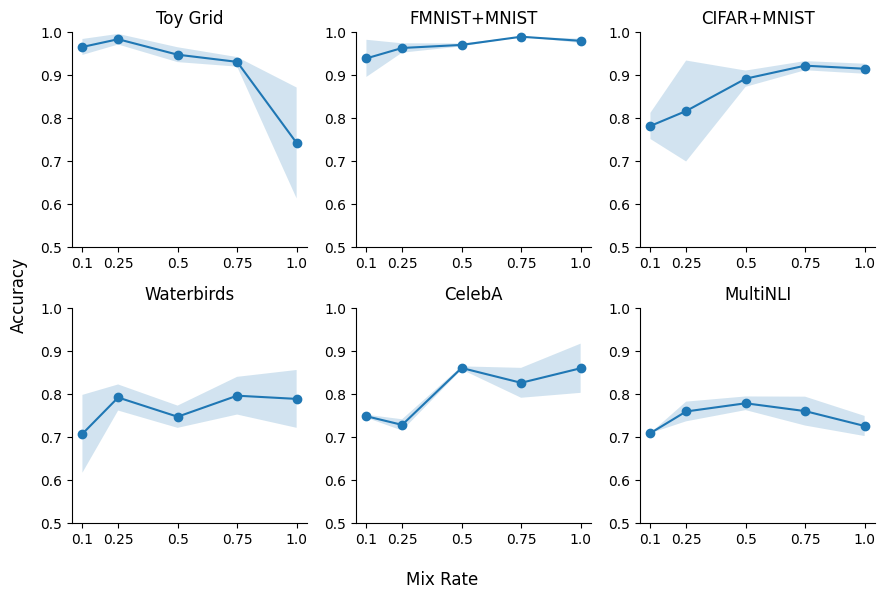

In [26]:
fig, axes = plot_acc_results_grid(acc_results, ignored_loss_types=ignored_loss_types, dataset_titles=dataset_titles)
fig.savefig(f"{EXP_DIR}/figures/cc_mix_rate.svg", bbox_inches="tight", dpi=300)
plt.show()


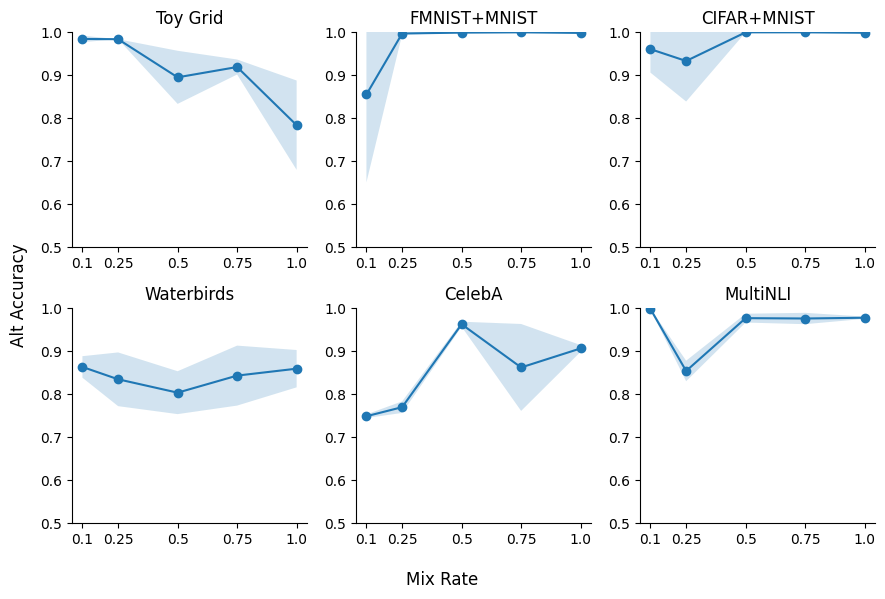

In [28]:

fig, axes = plot_acc_results_grid(alt_acc_results, ignored_loss_types=ignored_loss_types, 
                      dataset_titles=dataset_titles, ylabel="Alt Accuracy")
fig.savefig(f"{EXP_DIR}/figures/cc_mix_rate_alt.svg", bbox_inches="tight", dpi=300)
plt.show()

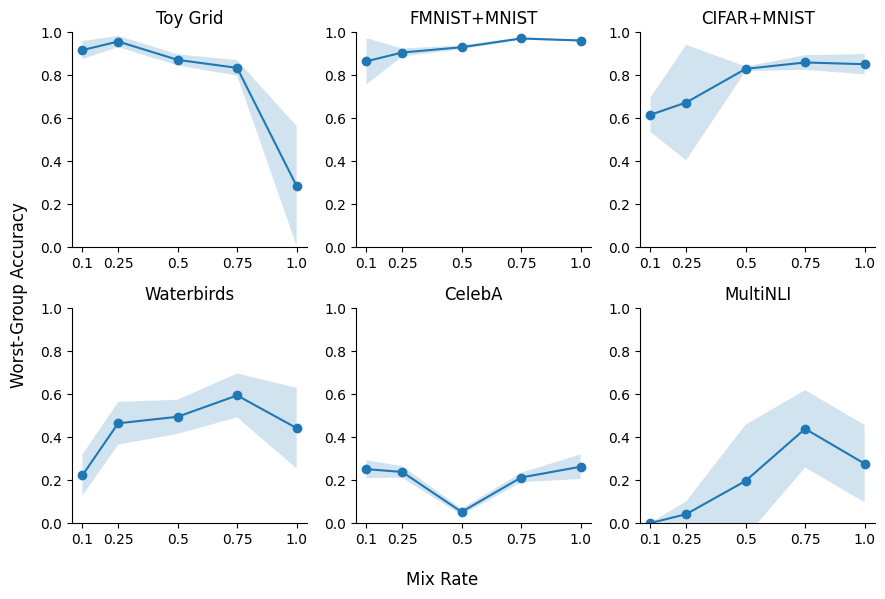

In [29]:

fig, axes = plot_acc_results_grid(worst_acc_results, 
                      ignored_loss_types=ignored_loss_types, ylim=(0.0, 1.0), 
                      dataset_titles=dataset_titles, 
                      ylabel="Worst-Group Accuracy")

fig.savefig(f"{EXP_DIR}/figures/cc_mix_rate_worst.svg", bbox_inches="tight", dpi=300)
plt.show()
